In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import seaborn as sns
import os
import re 
import sklearn.manifold
from collections import Counter
from gensim.models import Word2Vec

In [3]:
from clustering.embedding import WordEmbedding

In [5]:
#!python -m spacy download es_core_news_sm
#!python -m spacy download es_core_news_md
#nltk.download('punkt')
#nltk.download('wordnet')

In [6]:
df = pd.read_csv('data/datos_estructurados_malba')

<AxesSubplot:xlabel='Año', ylabel='Count'>

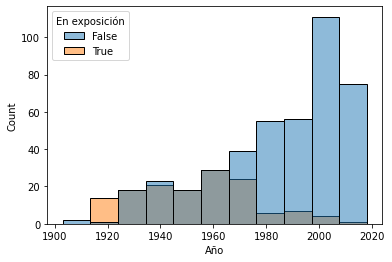

In [7]:
sns.histplot(data=df,x='Año',hue='En exposición',)

In [8]:
df.columns

Index(['URL_obra', 'Texto', 'URL_autor', 'Titulo', 'Año', 'Técnica', 'Medidas',
       'Nro. de inventario', 'Donación', 'En exposición', 'Duración'],
      dtype='object')

In [9]:
len(df['Técnica'].unique())

351

In [10]:
df['Técnica'].value_counts()

Óleo sobre tela                                                                             43
Copia heliográfica sobre papel. x/∞                                                         25
Tinta sobre papel                                                                           15
Lápiz sobre papel                                                                           14
Cartón y papel pintado                                                                      12
                                                                                            ..
Cintas de acero, brazos mecanicos de aluminio y motores en caja de madera esmaltada          1
Resina. Edición: 3/3                                                                         1
Tablero revestido en cuerina sobre caballetes; pieza torneada en madera con tapa de Coca     1
Lápiz color y grafito sobre papel                                                            1
Fotografía blanco y negro sobre papel, marco de ma

In [11]:
textos = (df.dropna(subset=['Texto']).Texto.values)

In [12]:
len(textos)

277

In [13]:
texto = "".join(textos).strip()

In [14]:
len(texto)

1542053

# Preprocesamos

Vamos a preprocesar:
- Eliminamos los números de las notas al pie, que son los números precedidos por puntos (.2 Blahblah)
- Reemplazamos \n3, \n, s\p por espacios
- Separamos en oraciones
- Lowercase todo
- Nos deshacemos de caracteres especiales
- Nos deshacemos de oraciones muy cortas

In [15]:
#texto = "Texto de Agustin Díez Fischer\n\xa0\nNotas\n1."

In [16]:
texto_limpio = re.sub("\d?\\n\d?\.?", "", texto)
texto_limpio = re.sub("\.\d", ". ", texto_limpio)
texto_limpio = re.sub("s\/p\.", ". ", texto_limpio)
puntos_mal = re.findall(".?\.[A-Z]",texto_limpio)

In [17]:
for elem in puntos_mal:
    if len(elem) == 2:
        repl = (elem[0] + ' ' + elem[1])
    elif len(elem) == 3:
        repl = (elem[0] + elem[1] + ' ' + elem[2])
    texto_limpio = texto_limpio.replace(elem, repl)

# Utilizamos contexto de oraciones 

In [18]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize.punkt import PunktTrainer, PunktSentenceTokenizer

In [19]:
pt = PunktSentenceTokenizer(texto_limpio,verbose=True)

In [20]:
sentences = pt.tokenize(texto_limpio)

In [21]:
len(sentences)

7625

In [22]:
sentences_len = [len(s) for s in sentences]

<AxesSubplot:ylabel='Count'>

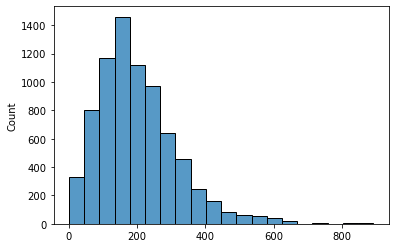

In [23]:
sns.histplot(x=sentences_len,bins=20)

In [24]:
sent_df = pd.DataFrame({'sent':sentences,'leng':sentences_len})

In [25]:
sent_df.sample(n=10)

,sent,leng
6198,"A la derecha, se sugiere la profundidad con lí...",93
3312,"Tras su realización en papel albanene, se copi...",143
5963,009. Archivo Víctor Magariños D. Ibid.,38
4086,"Con el proyecto Yaguareté, de 1998, Nicolás Ga...",105
7104,Dicho esquema tuvo su repercusión en el circui...,297
1005,"Finalmente, es necesario señalar que Manifesta...",407
4493,En la zona abdominal de la figura se personifi...,274
1511,Al igual que en el caso de otros artistas nort...,225
6814,"En este sentido, en Penalba, el ascetismo orie...",401
3233,"En esta ávida búsqueda de crear cosas nuevas, ...",291


In [26]:
len_threshold = 30
mask = sent_df['leng'] < len_threshold

In [27]:
sent_df[mask].count()

sent    179
leng    179
dtype: int64

In [28]:
sent_df[mask].sample(n=30)

,sent,leng
2405,1970-2010.,10
86,Cf. Alcida Rita Ramos.,22
5280,Obras 1982-1998.,16
4397,Una retrospectiva.,18
1795,¡Nunca más!,11
3331,158.,4
6338,"P. Dutton, 1976, p. 121.",24
1405,"Boto, Martha, “Recherches.",26
868,.,1
5099,Persistencia.,13


In [29]:
sent_df_long = sent_df[~mask]

In [30]:
sentences = sent_df_long.sent.values

In [31]:
np.random.choice(sentences,size=20)

array(['Desde su primera gran obra maestra, La Camera degli sposi (Homenaje a Mantegna), de 1958, ganadora del Salón Nacional de Artistas Colombianos, Botero encontró en los grupos familiares un tema para poder desarrollar en su pintura la interacción de sus personajes en grandes formatos, donde la monumentalidad de éstos se exacerbara.',
       'Aunque los fundadores formaban parte de la escena artística, quienes luego se incorporaron al CSC provenían de las más diversas instancias profesionales y sociales.',
       'Arden Quin empleó estos materiales para la Serie de transparencias, en la que los objetos fueron construidos a partir de cuadrados, círculos y rectángulos de vidrio, y para las partes extraíbles de la serie Estructuras extensas, compuesta por un conjunto de obras de madera con partes móviles.',
       'Fue en 1977 cuando Signos en ecosistemas artificiales, la presentación colectiva del grupo en la XIV Bienal de San Pablo, se alzó con el Gran Premio Itamaraty.',
       'De

In [32]:
len(sentences)

7446

# Tokenizamos y limpiamos un poco más

In [33]:
nlp = spacy.load("es_core_news_sm")

In [34]:
def normalize(text):
    text = text.lower()
    # Quitamos los guiones y los reemplazamos por espacios
    text = re.sub('-', ' ', text)
    # Quitamos caracteres espaeciales excepto acentos y dieresis
    text = re.sub('[^A-Za-z0-9  áéíóúÁÉÍÓÚüÜïÏÿñ]+', '', text)
    return text

def keep_token(token):
    return t.isalpha()

def tokenize(text):
    tokens = text.split(' ')
    return [t for t in tokens if t.isalpha()]

In [35]:
sents_tokens = [tokenize(normalize(sent)) for sent in sentences]

In [36]:
sentences[2]

'Ejemplo paradigmático del artista global, ha observado y pensado las realidades metropolitanas de todo el mundo, ha hecho obras sobre fronteras y guerras, y también se ha fascinado con las formas y metáforas de ciertos fenómenos climáticos.'

In [37]:
sents_joined_tokens = [" ".join(s) for s in sents_tokens]

In [38]:
sents_joined_tokens[:2]

['uno de los intereses más constantes en las investigaciones del artista belga mexicano francis alÿs a lo largo de su peripatética trayectoria ha sido todo lo que refiere a lo territorial',
 'con los años alÿs ha instaurado la caminata el recorrido el tránsito como las acciones medulares de su práctica y se ha convertido en un profesional del turismo crítico como dinámica y objeto artístico']

# Triplas de dependencia

In [39]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

In [40]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

In [41]:
spacy_text = " ".join(sentences)

In [42]:
len(spacy_text)

1535210

In [43]:
nlp = spacy.load("es_core_news_md")
nlp.max_length = 2000000

In [44]:
sent_threshold = 30

In [45]:
doc = nlp(spacy_text)

In [46]:
sents = [sent for sent in doc.sents if len(sent) > sent_threshold]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts = Counter(words_lemma)

In [47]:
len(counts)

12938

<AxesSubplot:ylabel='Count'>

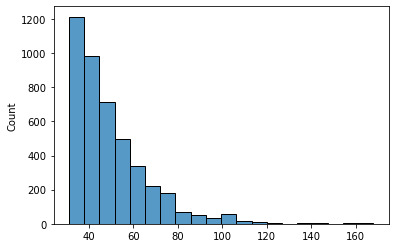

In [48]:
sns.histplot(x=[len(s) for s in sents],bins=20)

In [49]:
len(sents)

4401

In [50]:
len(counts)

12938

In [51]:
lemma_file = open("lemmatization-es.txt", "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

In [52]:
lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [53]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 3
threshold_c = 1

for word in words:
    w = lemmatize(word.lemma_)
    if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tags = parse_tags(word)
    for tag in tags:
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word.i == 0:
        context_izq = doc[word.i - 1]
        c_izq = lemmatize(context_izq.lemma_)
        if context_izq.is_alpha and counts[c_izq] > threshold_c:
            if str.isdigit(c_izq):
                c_izq = "NUM__"
            if not c_izq in features:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word.i < len(words):
        context_der = doc[word.i + 1]
        c_der = lemmatize(context_der.lemma_)
        if context_der.is_alpha and counts[c_der] > threshold_c:
            if str.isdigit(c_der):
                c_der = "NUM__"
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

In [54]:
len(dicc)

4906

In [55]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [56]:
len(features)

4906

In [57]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [58]:
matrix.shape

(4906, 81730)

In [59]:
matrix_normed = matrix / matrix.max(axis=0)

In [60]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [61]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [62]:
red_matrix.shape

(4906, 245)

In [63]:
matrix_normed.shape

(4906, 81730)

In [64]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [65]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

<AxesSubplot:xlabel='x', ylabel='y'>

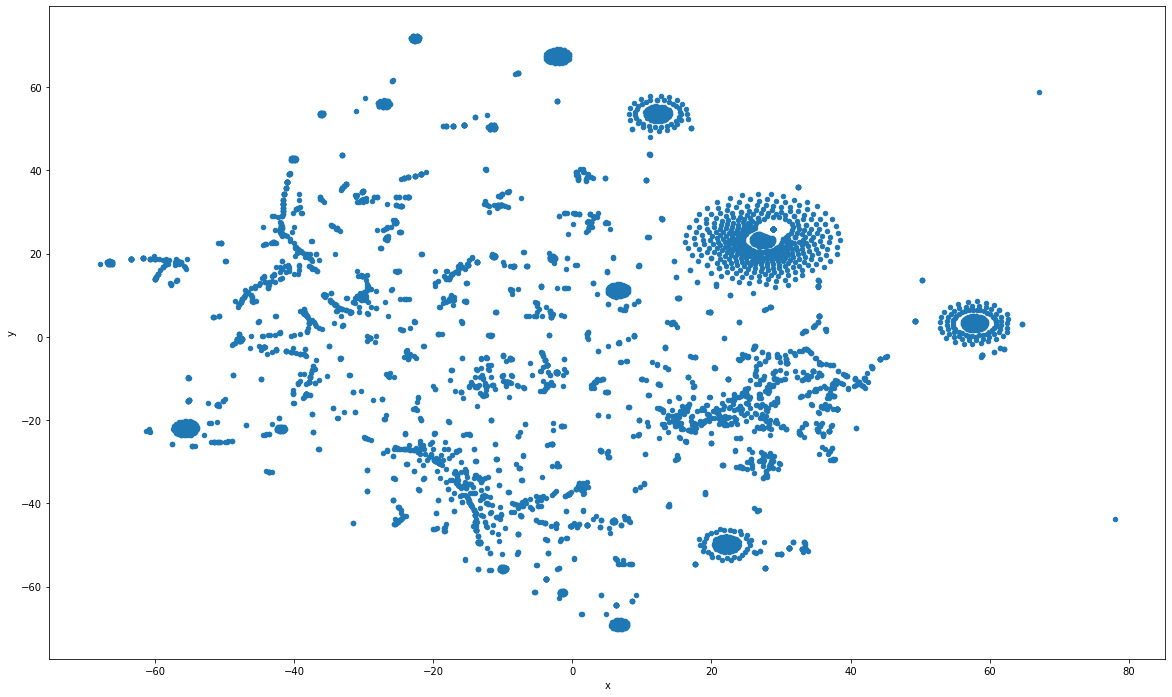

In [66]:

pointsspacy.plot.scatter("x", "y", s=20, figsize=(20, 12))

In [67]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(20, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

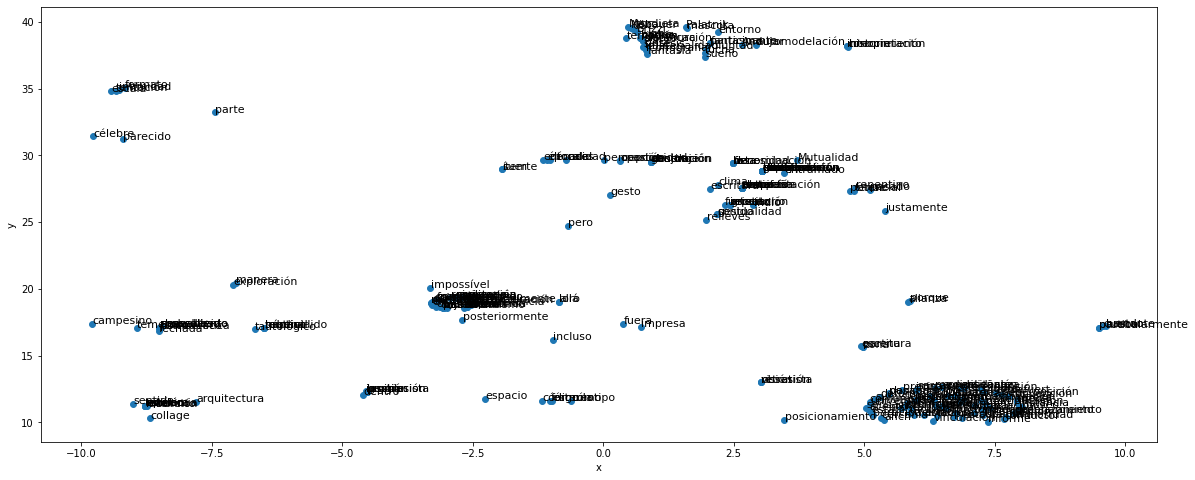

In [68]:
plot_region(x_bounds=(-10, 10), y_bounds=(10, 40))

In [74]:
from sklearn.cluster import KMeans

In [84]:
def clustering(k):
    clusterer = KMeans(k,random_state=321)
    clusters = clusterer.fit_predict(red_matrix, True)
    return clusterer, clusters

In [85]:
c50, preds = clustering(50)

In [88]:
filename = "models/malba_cluster50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

In [89]:
c100 = clustering(100)

In [92]:
filename = "models/malba_cluster100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

In [93]:
c150 = clustering(150)

In [94]:
filename = "models/malba_cluster150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [98]:
filename = "models/malba_cluster100.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [108]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[1][key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

<AxesSubplot:xlabel='x', ylabel='y'>

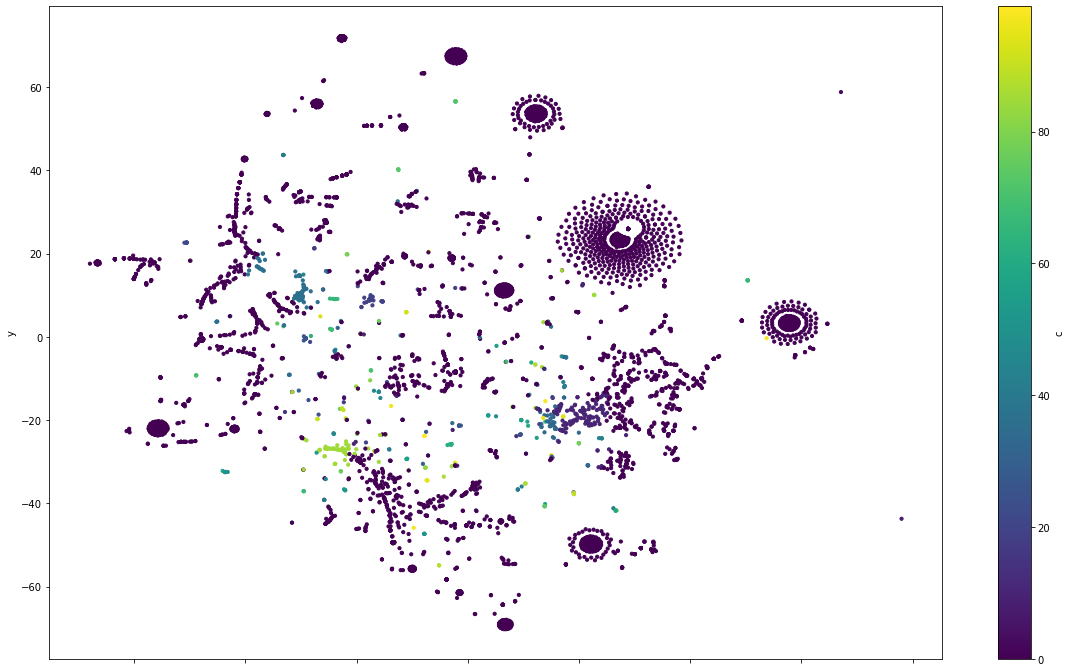

In [109]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [111]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

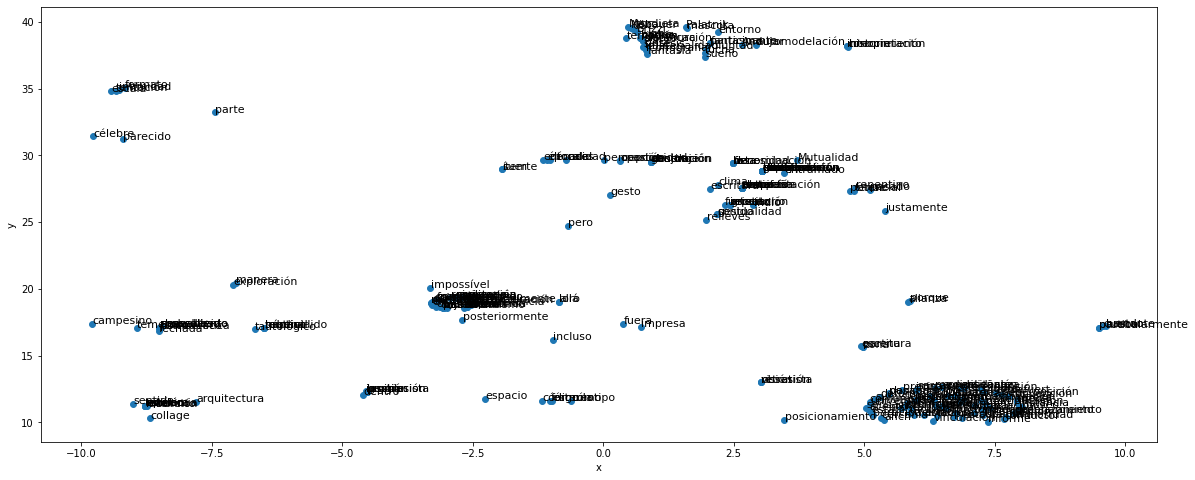

In [112]:
plot_region(x_bounds=(-10, 10), y_bounds=(10, 40))

# Word2vec

In [39]:
np.mean([len(s) for s in sents_tokens])

35.2775570272259

In [54]:
windows_size = 7
vector_size = 20
min_count = 5
epochs = 200
w2v_model = Word2Vec(sents_tokens, size=vector_size, window=windows_size, min_count=min_count,iter=epochs, workers=4, seed=1)
w2v_model.save(f"word2vec_size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

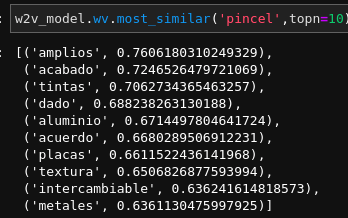

In [67]:
f'word2vec_size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}'

'word2vec_size=20__window=7__min_count=5__epochs=200'

In [55]:
len(w2v_model.wv.index2word)

4907

In [66]:
w2v_model.wv.most_similar('pincel',topn=10)

[('amplios', 0.7606180310249329),
 ('acabado', 0.7246526479721069),
 ('tintas', 0.7062734365463257),
 ('dado', 0.688238263130188),
 ('aluminio', 0.6714497804641724),
 ('acuerdo', 0.6680289506912231),
 ('placas', 0.6611522436141968),
 ('textura', 0.6506826877593994),
 ('intercambiable', 0.636241614818573),
 ('metales', 0.6361130475997925)]

In [68]:
w2v = WordEmbedding(wv=w2v_model.wv)

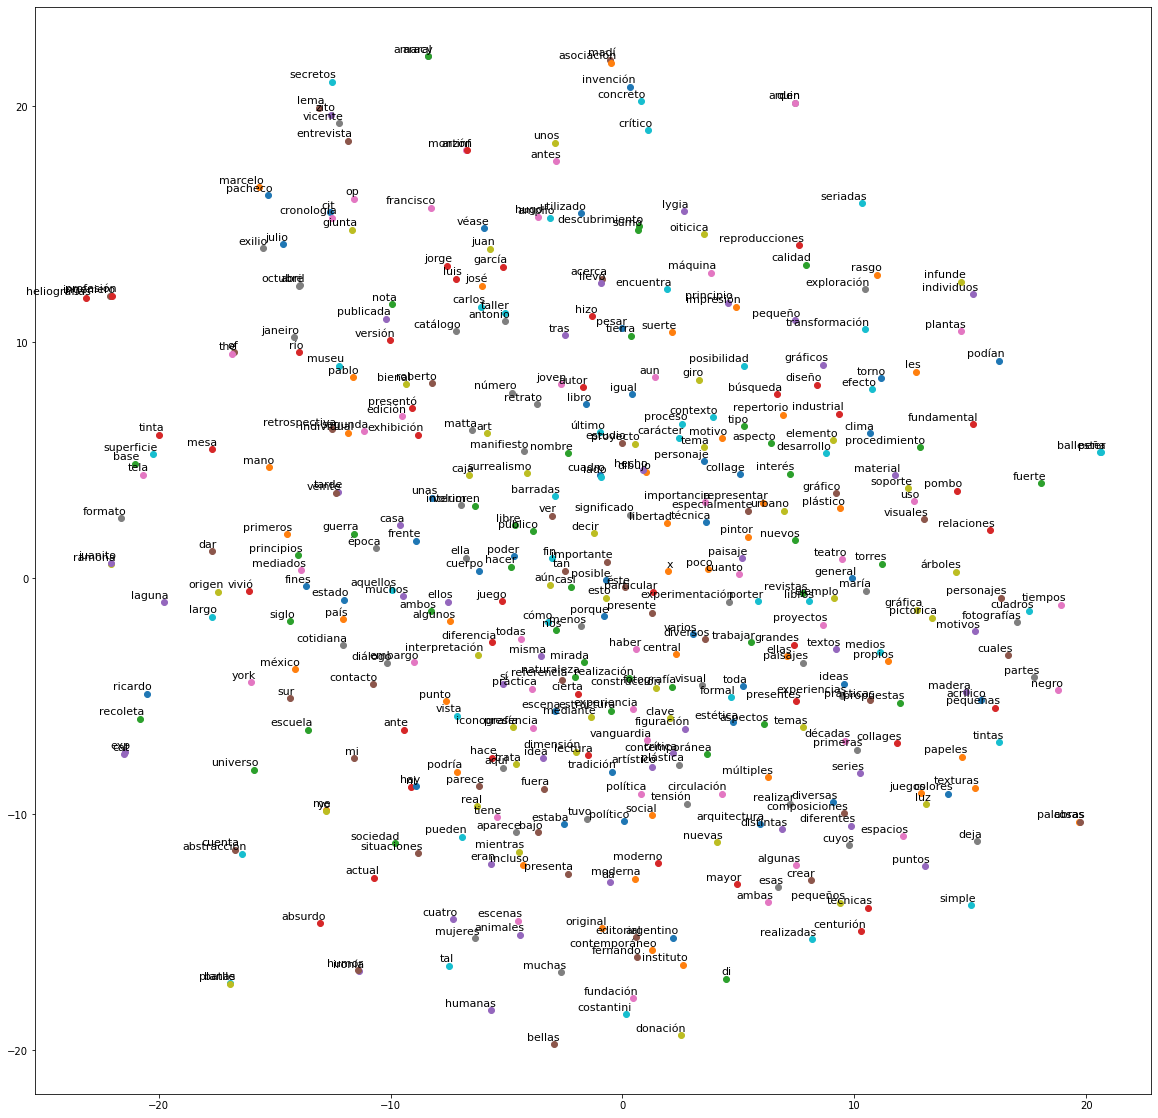

In [69]:
w2v.plot_tsne_proyection()

# Fasttext

In [70]:
from gensim.models.fasttext import FastText

In [71]:
windows_size = 5
vector_size = 10
min_count = 2
epochs=50

In [72]:
ft_model = FastText(
    size=vector_size, 
    window=windows_size,
    min_count=min_count,
)

In [73]:
ft_model.build_vocab(sentences=sents_tokens)

In [74]:
ft_model.train(sentences=sents_tokens, total_examples=len(sents_tokens), epochs=epochs)  # train
ft_model.save(f"fasttext__size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

In [75]:
ft = WordEmbedding(wv=ft_model.wv)

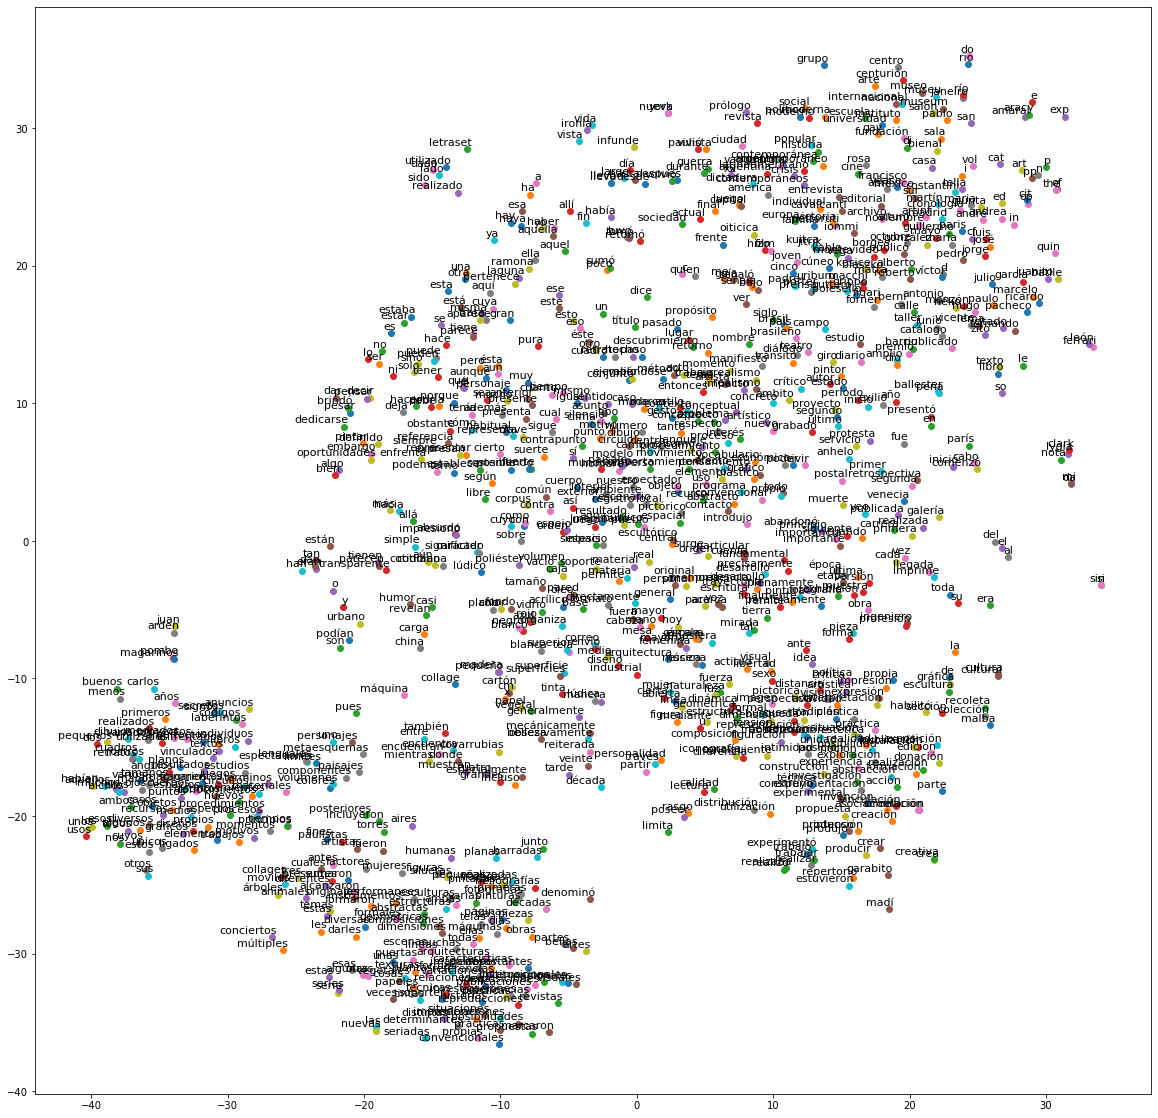

In [76]:
ft.plot_tsne_proyection(id_range=(0,1000))

Me gusta más Fasstext, incluso en la proyección ya se pueden observar cosas más interesantes

# Clustering

In [77]:
n_clusters = 50

In [78]:
ft.train_clustering(
    n_clusters=n_clusters,
    clustering_method='agglomerative')

In [79]:
ft.print_clustering_results()

46
['de', 'la', 'y', 'escultura', 'gráfica', 'distribución', 'arbitraria', 'heliográfica', 'requiriera', 'etc', 'fotográfica', 'mezcla', 'iconográfica', 'generó', 'mecánica', 'pesadilla', 'masculina', 'repleta', 'xilográfica', 'esperanza', 'polisémica', 'anuncian', 'tranquila', 'arbitrariedad', 'volcánica', 'alojó', 'autobiográfica', 'cinematográfica', 'biográfica']

----------------------------------------
22
['en', 'fue', 'año', 'berni', 'después', 'parís', 'antonio', 'taller', 'peña', 'ballester', 'cuatro', 'tarde', 'presentó', 'figari', 'volvió', 'film', 'pintó', 'transitó', 'diez', 'viajó', 'estadía', 'seis', 'enrique', 'empezó', 'emergen', 'apareció', 'bronce', 'obtuvo', 'españa', 'selva', 'recién', 'sede', 'sellawaj', 'bautizó', 'films', 'avance', 'pichon', 'visitó', 'usp', 'moma', 'antoni', 'mudó', 'rubén', 'tardía', 'homónima', 'frecuentó', 'muerto', 'sucedió', 'talabot', 'filmó', 'self', 'figueiredo', 'caricaturista', 'all', 'trelew', 'agregó', 'filho', 'ave', 'wall', 'antone

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [ ]:
kmeans.labels_

In [ ]:
from collections import defaultdict

In [ ]:
word_clusters = defaultdict(list)
for word,label in zip(ft_vectors.index2word , kmeans.labels_):
    word_clusters[label].append(word)

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=n_clusters)

In [ ]:
word_by_cluster = {word:cluster for word,cluster in zip(ft_vectors.index2word,kmeans.labels_)}

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab as plt

# obtener las palabras más comunes en el corpus, entre la 200 y la 600
words = [word for word in model_wv.index2word[200:1000]]

# convertirlas a vector
embeddings = [model_wv[word] for word in words]

#  T-SNEde
words_embedded = TSNE(n_components=2, random_state=1).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    cluster_color = cmap(norm(word_by_cluster[label]))
    plt.scatter(x, y, c=cluster_color)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

# Conversion a vector de TFIDF de oraciones

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk_stopwords = nltk.corpus.stopwords.words('spanish')

In [ ]:
tfidf = TfidfVectorizer(stop_words=nltk_stopwords,min_df=2)

In [ ]:
tfidf_sents = [" ".join(sent) for sent in norm_sents]

In [ ]:
tfidf_matrix = tfidf.fit_transform(tfidf_sents)

### Construiimos el vector de cada palabra como su ocurrencia en oraciones

In [ ]:
word_matrix = tfidf_matrix.transpose()

In [ ]:
word_matrix

# AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agc = AgglomerativeClustering(
    affinity='cosine',
    n_clusters=100,
    linkage='average')

In [ ]:
agc.n_clusters_

In [ ]:
clusters = agc.fit_predict(word_matrix.toarray())